In [2]:
#!pip install fedot

In [3]:
import os
os.environ["MKL_NUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"

import torch
torch.set_num_threads(4)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
logging.raiseExceptions = False

import fedot
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import TsForecastingParams, Task, TaskTypesEnum
import inspect

In [5]:
from google.colab import files
uploaded = files.upload()

Saving ts study 1.txt to ts study 1.txt


In [6]:
ts_tabular =pd.read_csv('ts study 1.txt')
ts_real_temp = ts_tabular[ts_tabular['label']=='temp'].drop('label',axis=1)['value'].to_numpy()

In [7]:
def s1(n,noise = 3,sign=1):
    def f1(x):
        return 5*np.sin(x/20)+0.1*x-2*np.sqrt(x)
    trend = f1(np.array(range(n)))
    noise = np.random.normal(loc = 0, scale = noise,size = n)
    ans = {'ts':(trend+noise)*sign, 'trend' : trend*sign}
    return ans
def s2(length, periods = 10,noise = 0.3,sign=1 ):

    sinusoidal_data = np.linspace(-periods * np.pi, periods * np.pi, length)
    sinusoidal_data = np.sin(sinusoidal_data)
    cos_1_data = np.linspace(-periods * np.pi/2, periods/2 * np.pi/2, int(length/2))
    cos_1_data = np.cos(cos_1_data) 
    cos_2_data = np.linspace(periods/2 * np.pi/2, periods * np.pi/2, int(length/2))
    cos_2_data = np.cos(cos_2_data)   
    cosine_data = np.hstack((cos_1_data, cos_2_data))
    
    random_noise = np.random.normal(loc=0.0, scale=noise, size=length)
    synthetic_data = sinusoidal_data + cosine_data + random_noise
    ans = {'ts':synthetic_data*sign, 'trend': (sinusoidal_data + cosine_data)*sign}
    return ans
def s3(n,noise = 10,sign = 1):
    r = np.array(range(n))
    trend = (r-r/5*np.sin(r/2)+r/2*np.sin(r/20))/10
    noise = np.random.normal(loc=0,scale = noise,size = n)
    ans = {'ts':(trend+noise)*sign, 'trend': trend*sign}
    return ans
def s4(n,noise = 1,sign =1):
    array = np.array(range(n))
    trend = array/5+np.power(array,0.5)*np.sin(np.pi/12*array)
    noise = np.random.normal(loc = 0,scale = noise, size = n)
    noise_cum = noise.cumsum()
    ts = trend+noise_cum
    ans = {'ts':ts*sign, 'trend' : trend*sign}
    return ans

def s5(n,noise = 1,sign=1):
    r= np.arange(n)
    trend = r*1
    noise = np.random.normal(loc=0,scale = noise,size = n)
    noise_cum = noise.cumsum()
    ts = trend+noise_cum
    ans = {'ts':ts*sign,'trend':trend*sign}
    return ans

def s6(n,noise = 1, sign =1):
    r = np.arange(n)
    trend = 2*np.sin(2*r)+np.cos(r)
    noise = np.random.normal(loc = 0,scale  = noise,size = n)
    ts = trend+noise
    ans = {'ts':ts,'trend':trend}
    return ans

In [32]:
horizon = 30
validation_blocks = 2
task = Task(TaskTypesEnum.ts_forecasting,  TsForecastingParams(forecast_length=horizon))
start = 0
end = 1000
series = 'traffic'

if series == 'traffic':
    init_series = ts_real_temp
    ts = init_series[start:end]
    trend = None
    ts_test = init_series[end:end+horizon]
    trend_test = None

if series ==1:
    noise = 0.5
    init_series = s1(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]  
    
if series ==2:
    noise = 0.5
    init_series = s2(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
    
if series ==3:
    noise = 0.5
    init_series = s3(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
    
if series ==4:
    noise = 0.5
    init_series = s4(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
  
if series ==5:
    noise = 1
    init_series = s5(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]   

if series ==6:
    noise = 0.5
    init_series = s6(10000,noise= noise,sign =1)
    ts = init_series['ts'][start:end]
    trend = init_series['trend'][start:end]
    ts_test = init_series['ts'][end:end+horizon]
    trend_test = init_series['trend'][end:end+horizon]
 
idx = np.array( range(len(np.array(ts))) )
train_input = InputData(idx=idx,
                            features=ts,
                            target=ts,
                            task=task,
                            data_type=DataTypesEnum.ts)
train_data, test_data = train_test_data_setup(train_input, validation_blocks=2)

# init model for the time series forecasting
model = Fedot(problem='ts_forecasting',
                  safe_mode = True,
                  task_params=task.task_params,
                  timeout=3,
                  n_jobs=-1,
                  cv_folds=2, 
                  validation_blocks=2, 
                  preset='ts',
                  with_tuning = False,
                  max_depth = 5,
                  num_of_generations  =3 ,
                  logging_level = 10,
                 show_progress =True)

In [12]:
#inspect.getmembers(model)

INFO:root:AssumptionsHandler - Initial pipeline fitting started


2022-11-23 11:49:43,340 - AssumptionsHandler - Initial pipeline fitting started


DEBUG:root:SecondaryNode - Trying to fit secondary node with operation: ridge


2022-11-23 11:49:43,352 - SecondaryNode - Trying to fit secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-23 11:49:43,357 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Trying to fit secondary node with operation: ridge


2022-11-23 11:49:43,362 - SecondaryNode - Trying to fit secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-23 11:49:43,366 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Trying to fit primary node with operation: lagged


2022-11-23 11:49:43,370 - PrimaryNode - Trying to fit primary node with operation: lagged


DEBUG:root:PrimaryNode - Trying to fit primary node with operation: glm


2022-11-23 11:49:43,503 - PrimaryNode - Trying to fit primary node with operation: glm


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-23 11:49:43,654 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-23 11:49:43,669 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-23 11:49:43,677 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-23 11:49:43,690 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-23 11:49:43,703 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: glm


2022-11-23 11:49:43,718 - PrimaryNode - Predict in primary node by operation: glm


INFO:root:AssumptionsHandler - Initial pipeline was fitted successfully


2022-11-23 11:49:43,728 - AssumptionsHandler - Initial pipeline was fitted successfully


CRITICAL:root:ApiComposer - Initial pipeline was fitted in 0.4 sec.


2022-11-23 11:49:43,742 - ApiComposer - Initial pipeline was fitted in 0.4 sec.


CRITICAL:root:ApiComposer - AutoML configured. Parameters tuning: False Time limit: 3 min Set of candidate models: ['sparse_lagged', 'glm', 'sgdr', 'lagged', 'pca', 'ts_naive_average', 'stl_arima', 'polyfit', 'dtreg', 'adareg', 'cut', 'ets', 'ridge', 'linear', 'locf', 'ar', 'gaussian_filter', 'scaling', 'fast_ica', 'smoothing', 'lasso', 'normalization', 'diff_filter', 'arima']


2022-11-23 11:49:43,766 - ApiComposer - AutoML configured. Parameters tuning: False Time limit: 3 min Set of candidate models: ['sparse_lagged', 'glm', 'sgdr', 'lagged', 'pca', 'ts_naive_average', 'stl_arima', 'polyfit', 'dtreg', 'adareg', 'cut', 'ets', 'ridge', 'linear', 'locf', 'ar', 'gaussian_filter', 'scaling', 'fast_ica', 'smoothing', 'lasso', 'normalization', 'diff_filter', 'arima']


CRITICAL:root:ApiComposer - Pipeline composition started.


2022-11-23 11:49:43,790 - ApiComposer - Pipeline composition started.


INFO:root:DataSourceSplitter - K-folds cross validation is applied.


2022-11-23 11:49:43,793 - DataSourceSplitter - K-folds cross validation is applied.


Generations:  33%|███▎      | 1/3 [00:00<?, ?gen/s]INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-23 11:49:43,801 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 1


2022-11-23 11:49:52,746 - EvoGraphOptimizer - Generation num: 1


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.869279349729279, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-23 11:49:52,762 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.869279349729279, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-23 11:49:52,776 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.1 min


2022-11-23 11:49:52,790 - EvoGraphOptimizer - spent time: 0.1 min


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-23 11:49:54,585 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 2


2022-11-23 11:50:14,492 - EvoGraphOptimizer - Generation num: 2


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.60767273873891, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-23 11:50:14,498 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.60767273873891, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 0 iterations


2022-11-23 11:50:14,503 - EvoGraphOptimizer - no improvements for 0 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.5 min


2022-11-23 11:50:14,507 - EvoGraphOptimizer - spent time: 0.5 min


INFO:root:EvoGraphOptimizer - Next population size: 34; max graph depth: 5


2022-11-23 11:50:14,511 - EvoGraphOptimizer - Next population size: 34; max graph depth: 5


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-23 11:50:15,398 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 3


2022-11-23 11:50:30,142 - EvoGraphOptimizer - Generation num: 3


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.60767273873891, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-23 11:50:30,150 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.60767273873891, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 1 iterations


2022-11-23 11:50:30,156 - EvoGraphOptimizer - no improvements for 1 iterations


INFO:root:EvoGraphOptimizer - spent time: 0.8 min


2022-11-23 11:50:30,160 - EvoGraphOptimizer - spent time: 0.8 min


INFO:root:EvoGraphOptimizer - Next population size: 55; max graph depth: 5


2022-11-23 11:50:30,171 - EvoGraphOptimizer - Next population size: 55; max graph depth: 5


INFO:root:MultiprocessingDispatcher - Number of used CPU's: 2


2022-11-23 11:50:31,589 - MultiprocessingDispatcher - Number of used CPU's: 2


INFO:root:EvoGraphOptimizer - Generation num: 4


2022-11-23 11:50:47,538 - EvoGraphOptimizer - Generation num: 4


INFO:root:EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.60767273873891, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


2022-11-23 11:50:47,544 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness: [{<bound method QualityMetric.get_value of <class 'fedot.core.composer.metrics.RMSE'>>: 4.60767273873891, <ComplexityMetricsEnum.node_num: 'node_number'>: 0.4}]


INFO:root:EvoGraphOptimizer - no improvements for 2 iterations


2022-11-23 11:50:47,549 - EvoGraphOptimizer - no improvements for 2 iterations


INFO:root:EvoGraphOptimizer - spent time: 1.1 min


2022-11-23 11:50:47,553 - EvoGraphOptimizer - spent time: 1.1 min


CRITICAL:root:GroupedCondition - Optimisation stopped: Max number of generations reached


2022-11-23 11:50:47,558 - GroupedCondition - Optimisation stopped: Max number of generations reached


Generations:  33%|███▎      | 1/3 [01:03<?, ?gen/s]
INFO:root:OptimisationTimer - Composition time: 1.063 min


2022-11-23 11:50:47,573 - OptimisationTimer - Composition time: 1.063 min


INFO:root:GPComposer - GP composition finished


2022-11-23 11:50:47,580 - GPComposer - GP composition finished


CRITICAL:root:ApiComposer - Model generation finished


2022-11-23 11:50:48,013 - ApiComposer - Model generation finished


CRITICAL:root:FEDOT logger - Final pipeline was fitted


2022-11-23 11:50:48,290 - FEDOT logger - Final pipeline was fitted


CRITICAL:root:FEDOT logger - Final pipeline: {'depth': 3, 'length': 4, 'nodes': [ridge, glm, ridge, lagged]}


2022-11-23 11:50:48,299 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 4, 'nodes': [ridge, glm, ridge, lagged]}


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-23 11:50:48,305 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-23 11:50:48,309 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Obtain prediction in secondary node with operation: ridge


2022-11-23 11:50:48,312 - SecondaryNode - Obtain prediction in secondary node with operation: ridge


DEBUG:root:SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


2022-11-23 11:50:48,316 - SecondaryNode - Fit all parent nodes in secondary node with operation: ridge


DEBUG:root:PrimaryNode - Predict in primary node by operation: lagged


2022-11-23 11:50:48,325 - PrimaryNode - Predict in primary node by operation: lagged


DEBUG:root:PrimaryNode - Predict in primary node by operation: glm


2022-11-23 11:50:48,336 - PrimaryNode - Predict in primary node by operation: glm


2022-11-23 11:50:48,402 - OperationTypesRepository - Operation lagged not found in the repository


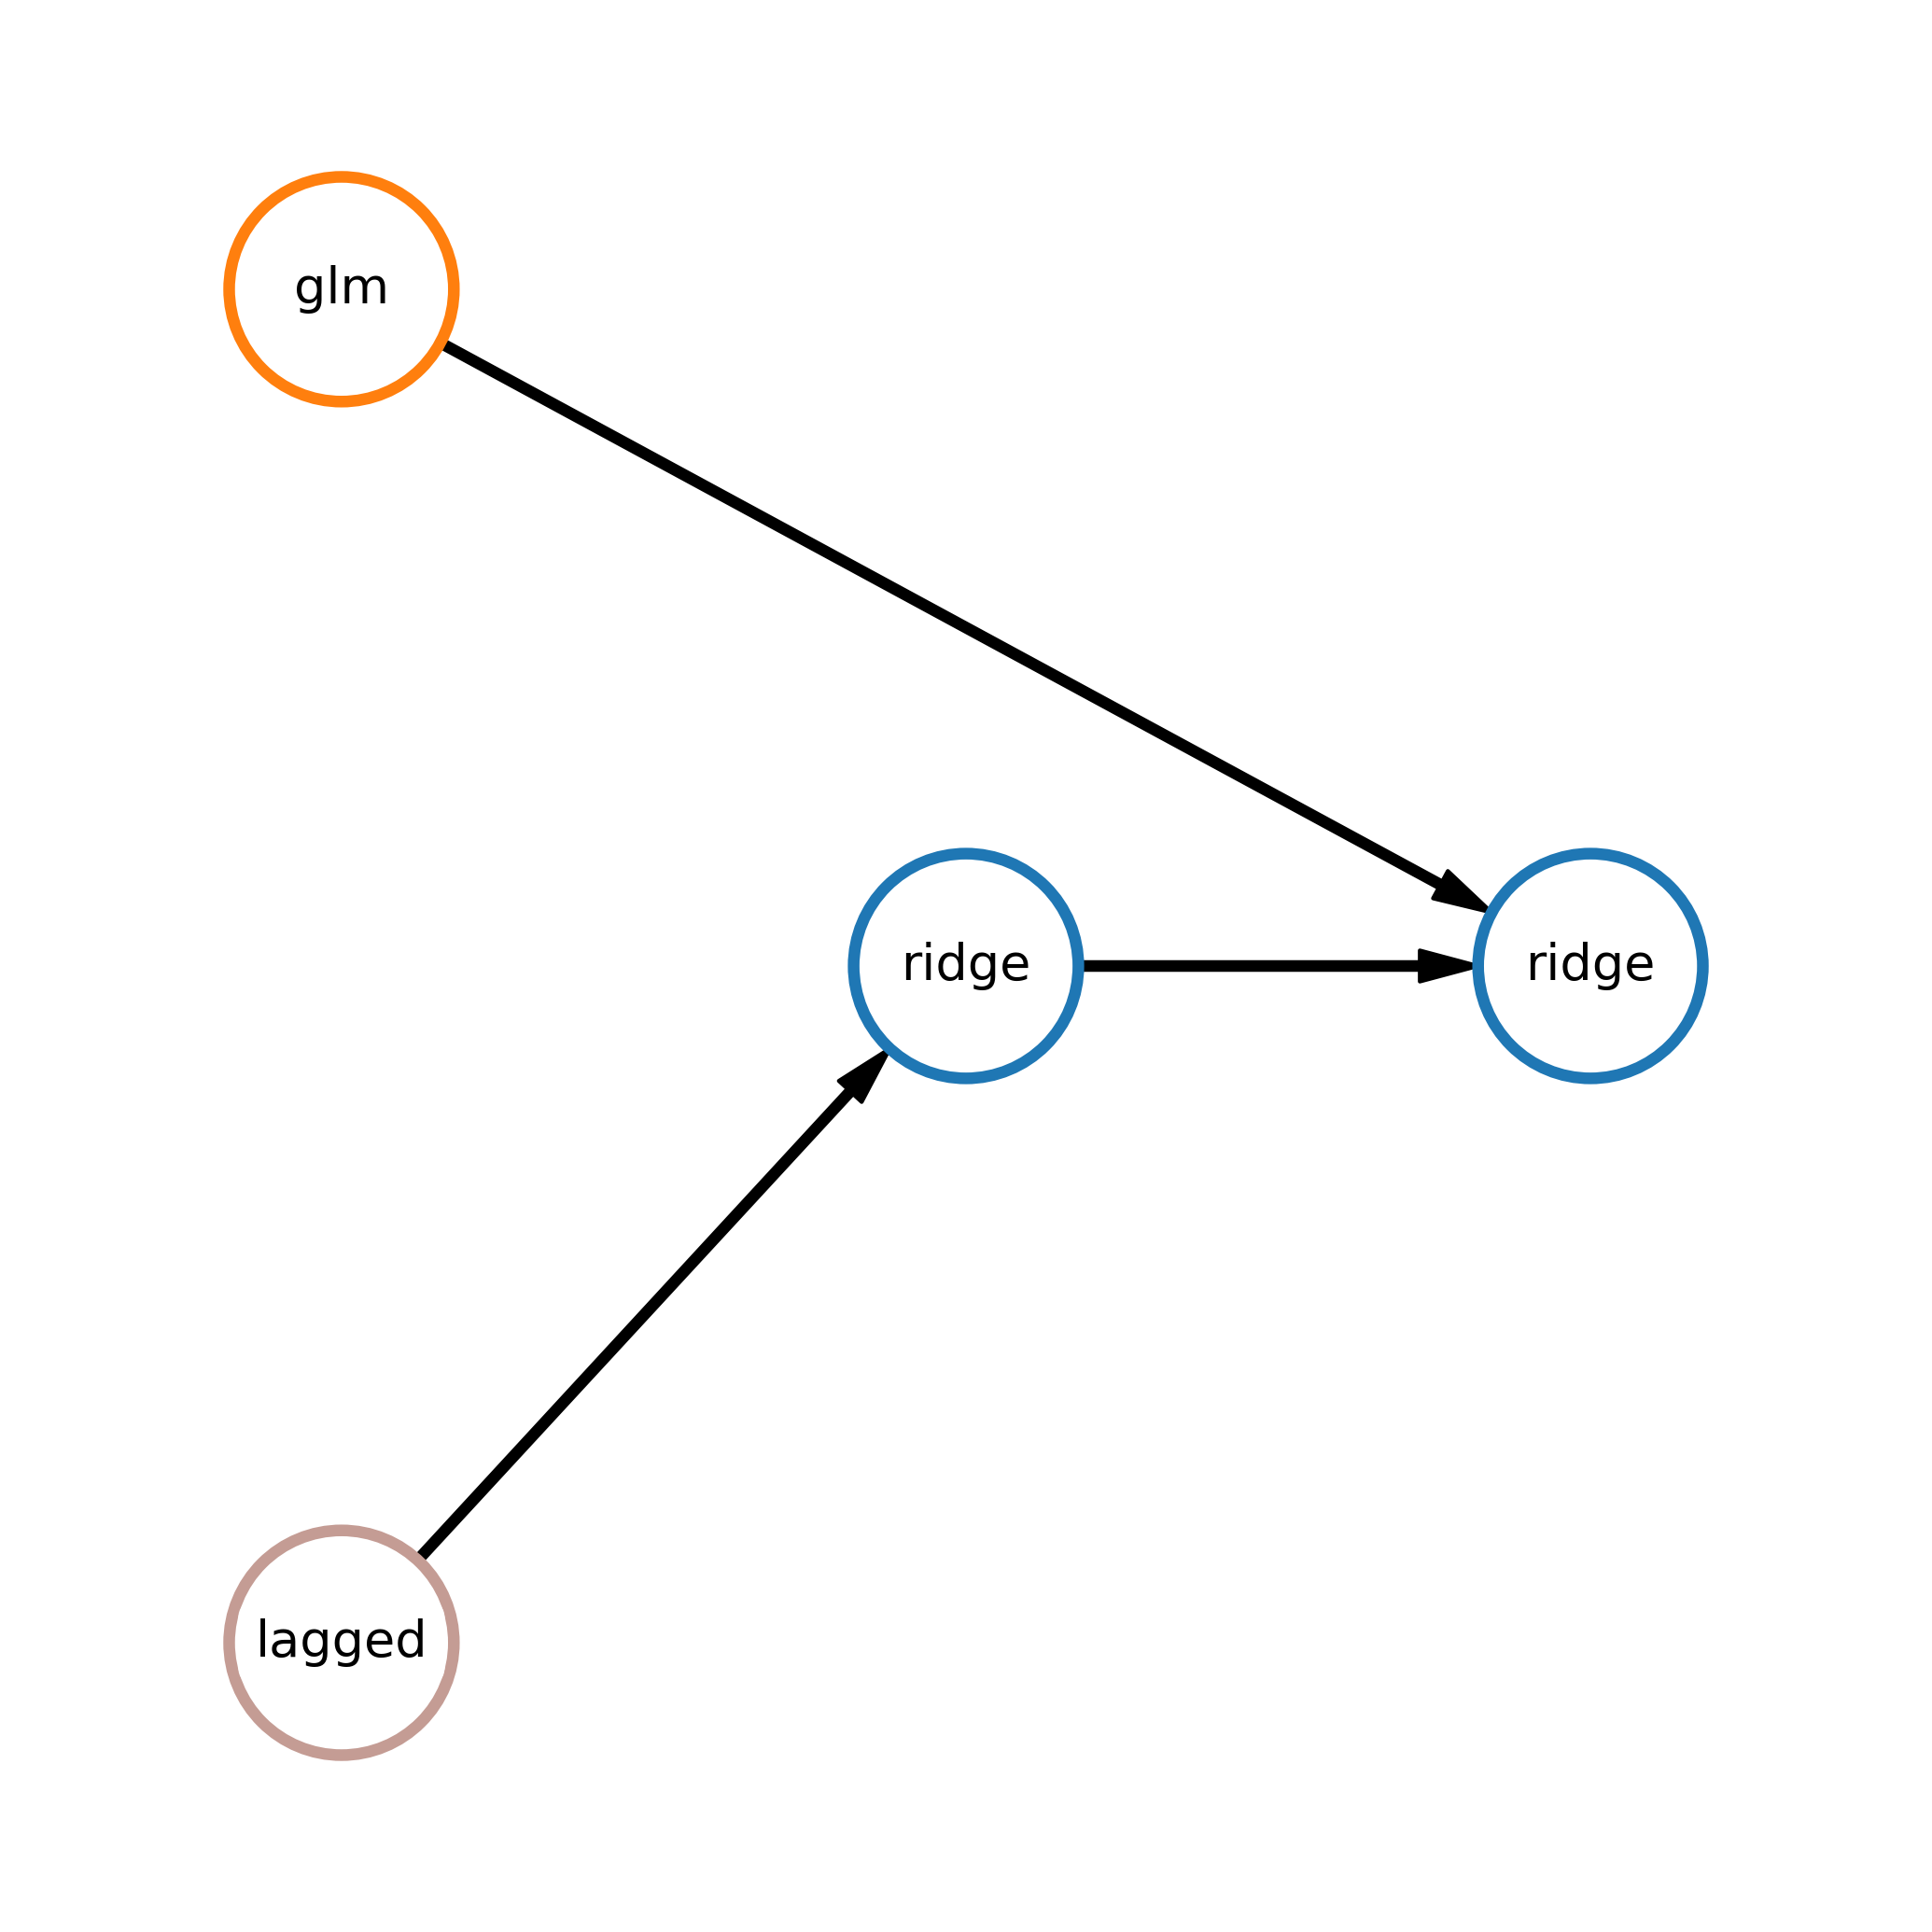

In [36]:
pipeline = model.fit(train_data)
forecast = model.forecast(test_data)
pipeline.show()

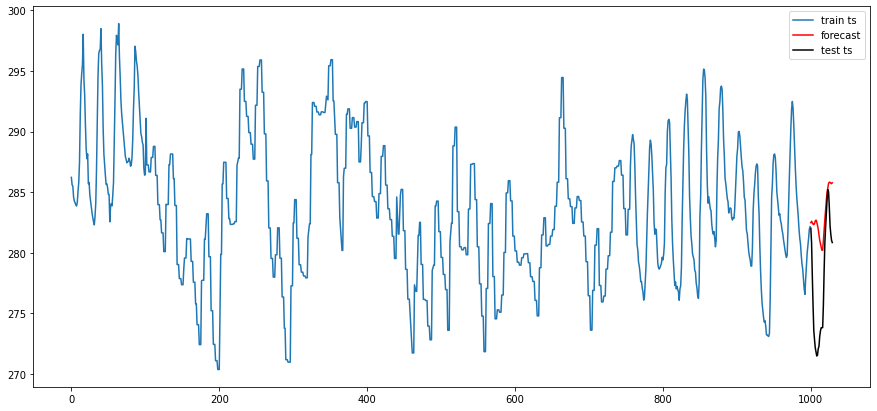

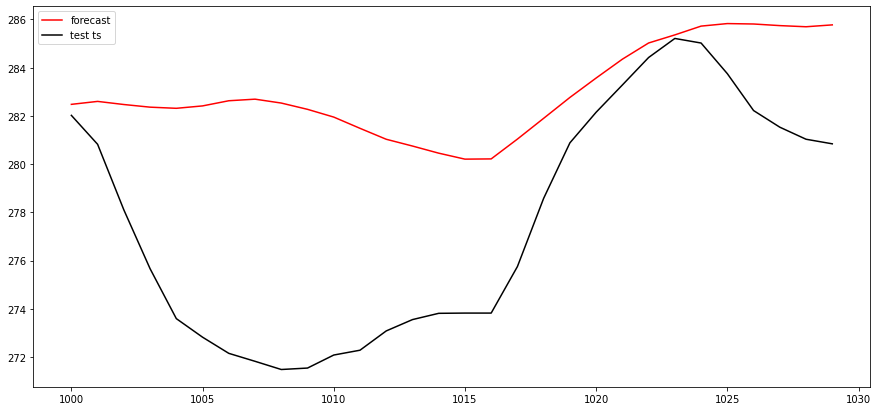

In [38]:
fig,ax  = plt.subplots()
fig.set(figwidth = 15,figheight = 7)
test_range = range(len(ts), len(ts)+len(ts_test))
test_range = range(end,end+horizon)
train_range = range(start,end)
total_range = range(start,end+horizon)

ax.plot(train_range,ts, label = 'train ts')
if trend is not None:
    ax.plot(train_range, trend,color = 'green',label = 'trend')
if trend_test is not None:
    ax.plot(test_range, trend_test,color = 'green')
ax.plot(test_range,forecast, color = 'red', label = 'forecast')
ax.plot(test_range, ts_test,color = 'black', label = 'test ts')
plt.legend();

fig1,ax1 = plt.subplots()
fig1.set(figwidth = 15,figheight = 7)

if trend_test is not None:
    ax1.plot(test_range, trend_test,color = 'green')
ax1.plot(test_range,forecast, color = 'red', label = 'forecast')
ax1.plot(test_range, ts_test,color = 'black', label = 'test ts')
plt.legend();

In [16]:
import sys
from sklearn.metrics import mean_squared_error as mse
from fedot.core.composer.metrics import QualityMetric
from fedot.core.data.data import InputData, OutputData
from fedot.core.repository.tasks import TsForecastingParams

def quantile_loss(y_true, y_pred, quantile=0.5):
    res = np.array(y_true)-np.array(y_pred)
    metrics=np.empty(shape = [0])
    for x in res:
        if x>=0:
            metrics = np.append(metrics, quantile*x)
        else:
            metrics = np.append(metrics,(quantile-1)*x)
    return np.mean(metrics)

class Quantile_Loss_1(QualityMetric):
    default_value = sys.maxsize

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        value = quantile_loss(reference.target, predicted.predict,quantile = 0.1)
        return value


class Quantile_Loss_9(QualityMetric):
    default_value = sys.maxsize

    @staticmethod
    def metric(reference: InputData, predicted: OutputData) -> float:
        value = quantile_loss(reference.target, predicted.predict,quantile = 0.9)
        return value

In [39]:
#importing for tuning
from fedot.core.optimisers.adapters import PipelineAdapter
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum
from fedot.core.pipelines.tuning.tuner_interface import HyperoptTuner
from fedot.core.pipelines.tuning.unified import PipelineTuner
from fedot.core.optimisers.composer_requirements import ComposerRequirements
import datetime

from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum

#these parameters are the same for both tuners below
task = Task(TaskTypesEnum.ts_forecasting,TsForecastingParams(forecast_length=horizon))
composer_requirements = ComposerRequirements()
composer_requirements.validation_blocks = 2
composer_requirements.n_jobs= -1
composer_requirements.show_progress = True

#this tuner will be used to create lower confidence interval
low_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(Quantile_Loss_1.get_value) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

#this tuner will be used to create uppper confidence interval
up_tuner = TunerBuilder(task = task) \
         .with_tuner(PipelineTuner) \
         .with_metric(Quantile_Loss_9.get_value) \
         .with_iterations(10) \
         .with_timeout(datetime.timedelta(minutes=2)) \
         .with_requirements(composer_requirements) \
         .build(train_data)

INFO:root:DataSourceSplitter - Hold out validation is applied.


2022-11-23 11:52:09,436 - DataSourceSplitter - Hold out validation is applied.


INFO:root:DataSourceSplitter - Hold out validation is applied.


2022-11-23 11:52:09,446 - DataSourceSplitter - Hold out validation is applied.


In [40]:
def quantile_maker(quantile,arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    up = []
    low = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        q_up = np.quantile(x, 1-quantile)
        up.append(q_up)
        q_low = np.quantile(x,quantile)
        low.append(q_low)
    up = np.array(up)
    low = np.array(low)
    return {'up':up,'low':low}

def mean_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    average = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        average.append(x.mean())
    return average

def median_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    median = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        median.append(np.median(x))
    return median

def absolute_maker(arrays):
    number_arrays = len(arrays)
    l = len(arrays[0])
    maximum = []
    minimum = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        maximum.append(np.max(x))
        minimum.append(np.min(x))
    return {'up':np.array(maximum),'low':np.array(minimum)}

from scipy.stats import trim_mean
def truncated_mean_maker(arrays, quantile=0.1):
    number_arrays = len(arrays)
    l = len(arrays[0])
    trunc_mean = []
    for i in range(l):
        x = np.array([arrays[j][i] for j in range(number_arrays)])
        trunc_mean.append(trim_mean(x, quantile))
    return np.array(trunc_mean)

In [41]:
def conf_int_maker(model = model,
                   train_ts = ts,
                   number_models = 10, 
                   pipelines_show= False):
    """
    model - a fedot model of interest
    train_ts - the ts used for training the model
    ts_test - the testing series; used for plotting and visualization of the results
    number_models - number of models used to create the confidence intervals
    regim - type of getting lower and upper confidence intervals from the upper and lower arrays; 
            default is 'quantile' also avaliable 'average' and 'median', 'absolute_bounds', 'truncated_mean'
    plot - boolean parameter indicating wheter to show plot of the forecast and confidence intervals
    plot_history - boolean parameter indicating whether to show previous series
    """
    
    horizon = model.params.task.task_params.forecast_length
    train_data = model.train_data
    test_data = model.test_data
    forecast = model.predict(test_data)

    #4 lines below allow us take the best models
    fits = []
    for ind in model.history.individuals[-1]:
        fits.append(ind.fitness.value)
    fits = np.sort(np.array(fits))

    #create up and low predictions
    up_predictions = []
    low_predictions = []
    
    s=1
    for ind in model.history.individuals[-1]:
        if ind.fitness.value<=fits[number_models]:
            pipeline = PipelineAdapter().restore(ind.graph)
            print(f'Fitting pipeline №{s}')
            s+=1
            if pipelines_show:
                pipeline.show()
            
            
            #tuning upper confidence interval
            tuned_pipeline = up_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            up_predictions.append(preds)
            del tuned_pipeline
            
            #tuning lower confidence interval
            tuned_pipeline = low_tuner.tune(pipeline)
            tuned_pipeline.fit(train_data)
            preds = tuned_pipeline.predict(test_data).predict.ravel()
            low_predictions.append(preds)
            del tuned_pipeline
    return {'up_predictions':up_predictions, 'low_predictions':low_predictions}

In [42]:
def conf_int_plotting(up_predictions,
                      low_predictions,
                      horizon=horizon,
                      forecast=forecast,
                      ts=ts,
                      ts_test=ts_test,
                      trend_test=trend_test,
                      regim = 'quantile',
                      plot_history = True,
                      plot_up_int = True,
                      plot_low_int = True,
                      plot_trend = True,
                      plot_forecast = True,
                      plot_upper_train = True,
                      plot_lower_train = True,
                      plot_ts_test = True):
    if regim == 'quantile':
        up_res= quantile_maker(quantile = 0.1, arrays = up_predictions)['up']
        low_res= quantile_maker(quantile = 0.1, arrays = low_predictions)['low']
    if regim == 'mean':
        up_res = mean_maker(arrays = up_predictions)
        low_res = mean_maker(arrays = low_predictions)
    if regim == 'median':
        up_res = median_maker(arrays = up_predictions)
        low_res = median_maker(arrays = low_predictions)
    if regim == 'absolute_bounds':
        up_res = absolute_maker(arrays = up_predictions)['up']
        low_res = absolute_maker(arrays = low_predictions)['low']
    if regim == 'truncated_mean':
        up_res = truncated_mean_maker(arrays = up_predictions)
        low_res = truncated_mean_maker(arrays = low_predictions)
    
    up = np.maximum(up_res,forecast)  
    low = np.minimum(low_res,forecast)

    r = range(1,horizon+1)
    fig,ax = plt.subplots()
    fig.set(figwidth = 15,figheight = 7)
    for i in range(len(up_predictions)):
        if i==0:
            if plot_upper_train:
                ax.plot(r,up_predictions[i], color = 'yellow',label = 'preds for up train')
            if plot_lower_train:
                ax.plot(r,low_predictions[i], color = 'pink',label = 'preds for low train')
        else:
            if plot_upper_train:
                ax.plot(r,up_predictions[i], color = 'yellow')
            if plot_lower_train:
                ax.plot(r,low_predictions[i], color = 'pink')    
    if plot_up_int:
        ax.plot(r,up, color = 'blue', label  = 'Up',marker= '.')
    if plot_low_int:
        ax.plot(r,low, color = 'green', label  = 'Low',marker = '.')
    if plot_forecast:
        ax.plot(r,forecast, color = 'red', label = 'Forecast')
    if ts_test is not None:
        if plot_ts_test:
            ax.plot(r,ts_test,color = 'black', label = 'Actual TS')
    if trend_test is not None:
        if plot_trend:
            ax.plot(r, trend_test, color = 'magenta', label = 'True Trend')
    plt.legend()
    if plot_history:
        fig1,ax1 = plt.subplots()
        
        fig1.set(figwidth = 15,figheight = 7)
       
        train_range = range(len(ts))
        test_range = range(len(ts),len(ts)+horizon)
        
        ax1.plot(train_range,ts, color = 'gray',label = 'Train ts')
        ax1.plot(test_range, up,color = 'blue', label = 'Up')
        ax1.plot(test_range, low,color = 'green', label = 'Low')
        ax1.plot(test_range,forecast, color = 'red', label = 'Forecast')
        if ts_test is not None:
            ax1.plot(test_range, ts_test,color = 'black', label = 'Actual TS')  
        if trend_test is not None:
            ax1.plot(test_range, trend_test, color = 'magenta', label = 'True Trend')
        plt.legend();

In [43]:
x = conf_int_maker(model = model, number_models =7,pipelines_show = False)

INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №1
2022-11-23 11:52:22,308 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005877 seconds


2022-11-23 11:52:22,601 - build_posterior_wrapper took 0.005877 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:52:22,609 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:05,  1.70trial/s, best loss: 1.8127275343761764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007153 seconds


2022-11-23 11:52:23,193 - build_posterior_wrapper took 0.007153 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.812728


2022-11-23 11:52:23,210 - TPE using 1/1 trials with best loss 1.812728
 20%|██        | 2/10 [00:01<00:07,  1.11trial/s, best loss: 1.8127275343761764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008383 seconds


2022-11-23 11:52:24,319 - build_posterior_wrapper took 0.008383 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.812728


2022-11-23 11:52:24,335 - TPE using 2/2 trials with best loss 1.812728
 30%|███       | 3/10 [00:03<00:08,  1.23s/trial, best loss: 1.8127275343761764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006369 seconds


2022-11-23 11:52:25,923 - build_posterior_wrapper took 0.006369 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.812728


2022-11-23 11:52:25,938 - TPE using 3/3 trials with best loss 1.812728
 40%|████      | 4/10 [00:04<00:06,  1.12s/trial, best loss: 1.8127275343761764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006719 seconds


2022-11-23 11:52:26,886 - build_posterior_wrapper took 0.006719 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.812728


2022-11-23 11:52:26,900 - TPE using 4/4 trials with best loss 1.812728
 50%|█████     | 5/10 [00:04<00:04,  1.11trial/s, best loss: 1.8127275343761764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007905 seconds


2022-11-23 11:52:27,398 - build_posterior_wrapper took 0.007905 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.812728


2022-11-23 11:52:27,402 - TPE using 5/5 trials with best loss 1.812728
 60%|██████    | 6/10 [00:06<00:04,  1.15s/trial, best loss: 1.8127275343761764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012885 seconds


2022-11-23 11:52:29,023 - build_posterior_wrapper took 0.012885 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.812728


2022-11-23 11:52:29,031 - TPE using 6/6 trials with best loss 1.812728
 70%|███████   | 7/10 [00:06<00:02,  1.08trial/s, best loss: 1.8127275343761764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005798 seconds


2022-11-23 11:52:29,496 - build_posterior_wrapper took 0.005798 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.812728


2022-11-23 11:52:29,507 - TPE using 7/7 trials with best loss 1.812728
 80%|████████  | 8/10 [00:08<00:02,  1.12s/trial, best loss: 1.8127275343761764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007276 seconds


2022-11-23 11:52:31,022 - build_posterior_wrapper took 0.007276 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.812728


2022-11-23 11:52:31,029 - TPE using 8/8 trials with best loss 1.812728
 90%|█████████ | 9/10 [00:08<00:00,  1.11trial/s, best loss: 1.8127275343761764]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006927 seconds


2022-11-23 11:52:31,441 - build_posterior_wrapper took 0.006927 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.812728


2022-11-23 11:52:31,449 - TPE using 9/9 trials with best loss 1.812728
100%|██████████| 10/10 [00:09<00:00,  1.03trial/s, best loss: 1.8127275343761764]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:52:32,870 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 1.813 worse than initial (+ 5% deviation) 0.602


2022-11-23 11:52:32,881 - PipelineTuner - Return init pipeline due to the fact that obtained metric 1.813 worse than initial (+ 5% deviation) 0.602


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-23 11:52:33,150 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006213 seconds


2022-11-23 11:52:33,725 - build_posterior_wrapper took 0.006213 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:52:33,738 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:12,  1.40s/trial, best loss: 15.281806426220816]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007299 seconds


2022-11-23 11:52:35,131 - build_posterior_wrapper took 0.007299 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 15.281806


2022-11-23 11:52:35,138 - TPE using 1/1 trials with best loss 15.281806
 20%|██        | 2/10 [00:02<00:10,  1.27s/trial, best loss: 3.6893825733980656]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005761 seconds


2022-11-23 11:52:36,311 - build_posterior_wrapper took 0.005761 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 3.689383


2022-11-23 11:52:36,325 - TPE using 2/2 trials with best loss 3.689383
 30%|███       | 3/10 [00:03<00:06,  1.05trial/s, best loss: 1.3367811858109373]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006271 seconds


2022-11-23 11:52:36,884 - build_posterior_wrapper took 0.006271 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.336781


2022-11-23 11:52:36,892 - TPE using 3/3 trials with best loss 1.336781
 40%|████      | 4/10 [00:04<00:07,  1.27s/trial, best loss: 1.3367811858109373]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006439 seconds


2022-11-23 11:52:38,642 - build_posterior_wrapper took 0.006439 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.336781


2022-11-23 11:52:38,662 - TPE using 4/4 trials with best loss 1.336781
 50%|█████     | 5/10 [00:06<00:06,  1.29s/trial, best loss: 1.3367811858109373]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006905 seconds


2022-11-23 11:52:39,960 - build_posterior_wrapper took 0.006905 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.336781


2022-11-23 11:52:39,966 - TPE using 5/5 trials with best loss 1.336781
 60%|██████    | 6/10 [00:07<00:04,  1.19s/trial, best loss: 1.3367811858109373]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006921 seconds


2022-11-23 11:52:40,947 - build_posterior_wrapper took 0.006921 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.336781


2022-11-23 11:52:40,954 - TPE using 6/6 trials with best loss 1.336781
 70%|███████   | 7/10 [00:08<00:03,  1.26s/trial, best loss: 1.3367811858109373]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007652 seconds


2022-11-23 11:52:42,363 - build_posterior_wrapper took 0.007652 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.336781


2022-11-23 11:52:42,372 - TPE using 7/7 trials with best loss 1.336781
 80%|████████  | 8/10 [00:09<00:02,  1.03s/trial, best loss: 1.278702774376421] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006767 seconds


2022-11-23 11:52:42,916 - build_posterior_wrapper took 0.006767 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.278703


2022-11-23 11:52:42,929 - TPE using 8/8 trials with best loss 1.278703
 90%|█████████ | 9/10 [00:10<00:01,  1.04s/trial, best loss: 1.278702774376421]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007612 seconds


2022-11-23 11:52:43,967 - build_posterior_wrapper took 0.007612 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.278703


2022-11-23 11:52:43,975 - TPE using 9/9 trials with best loss 1.278703
100%|██████████| 10/10 [00:10<00:00,  1.06s/trial, best loss: 1.2310316268310346]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:52:44,581 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.231 equal or better than initial (+ 5% deviation) 1.384


2022-11-23 11:52:44,587 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.231 equal or better than initial (+ 5% deviation) 1.384


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №2
2022-11-23 11:52:44,882 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002830 seconds


2022-11-23 11:52:45,062 - build_posterior_wrapper took 0.002830 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:52:45,068 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:12,  1.35s/trial, best loss: 7.8082028580598175]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002681 seconds


2022-11-23 11:52:46,411 - build_posterior_wrapper took 0.002681 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 7.808203


2022-11-23 11:52:46,417 - TPE using 1/1 trials with best loss 7.808203
 20%|██        | 2/10 [00:01<00:05,  1.48trial/s, best loss: 1.3530358605009667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004168 seconds


2022-11-23 11:52:46,619 - build_posterior_wrapper took 0.004168 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.353036


2022-11-23 11:52:46,626 - TPE using 2/2 trials with best loss 1.353036
 30%|███       | 3/10 [00:02<00:04,  1.42trial/s, best loss: 1.3530358605009667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002615 seconds


2022-11-23 11:52:47,356 - build_posterior_wrapper took 0.002615 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.353036


2022-11-23 11:52:47,362 - TPE using 3/3 trials with best loss 1.353036
 40%|████      | 4/10 [00:02<00:03,  1.91trial/s, best loss: 1.3530358605009667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002705 seconds


2022-11-23 11:52:47,604 - build_posterior_wrapper took 0.002705 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.353036


2022-11-23 11:52:47,611 - TPE using 4/4 trials with best loss 1.353036
 50%|█████     | 5/10 [00:02<00:01,  2.52trial/s, best loss: 0.3165661565616187]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002664 seconds


2022-11-23 11:52:47,776 - build_posterior_wrapper took 0.002664 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.316566


2022-11-23 11:52:47,782 - TPE using 5/5 trials with best loss 0.316566
 60%|██████    | 6/10 [00:03<00:01,  2.29trial/s, best loss: 0.3165661565616187]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002353 seconds


2022-11-23 11:52:48,289 - build_posterior_wrapper took 0.002353 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.316566


2022-11-23 11:52:48,299 - TPE using 6/6 trials with best loss 0.316566
 70%|███████   | 7/10 [00:04<00:01,  1.52trial/s, best loss: 0.3165661565616187]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003096 seconds


2022-11-23 11:52:49,403 - build_posterior_wrapper took 0.003096 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.316566


2022-11-23 11:52:49,414 - TPE using 7/7 trials with best loss 0.316566
 80%|████████  | 8/10 [00:04<00:01,  1.61trial/s, best loss: 0.3165661565616187]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002338 seconds


2022-11-23 11:52:49,941 - build_posterior_wrapper took 0.002338 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.316566


2022-11-23 11:52:49,956 - TPE using 8/8 trials with best loss 0.316566
 90%|█████████ | 9/10 [00:05<00:00,  1.59trial/s, best loss: 0.3165661565616187]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002695 seconds


2022-11-23 11:52:50,601 - build_posterior_wrapper took 0.002695 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.316566


2022-11-23 11:52:50,616 - TPE using 9/9 trials with best loss 0.316566
100%|██████████| 10/10 [00:05<00:00,  1.73trial/s, best loss: 0.3165661565616187]

INFO:root:PipelineTuner - Hyperparameters optimization finished



2022-11-23 11:52:51,017 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.317 equal or better than initial (+ 5% deviation) 0.391


2022-11-23 11:52:51,028 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.317 equal or better than initial (+ 5% deviation) 0.391


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-23 11:52:51,201 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003174 seconds


2022-11-23 11:52:51,388 - build_posterior_wrapper took 0.003174 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:52:51,395 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:01,  5.13trial/s, best loss: 1.750408110495396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002618 seconds


2022-11-23 11:52:51,585 - build_posterior_wrapper took 0.002618 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.750408


2022-11-23 11:52:51,592 - TPE using 1/1 trials with best loss 1.750408
 20%|██        | 2/10 [00:00<00:03,  2.00trial/s, best loss: 1.750408110495396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002835 seconds


2022-11-23 11:52:52,300 - build_posterior_wrapper took 0.002835 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.750408


2022-11-23 11:52:52,306 - TPE using 2/2 trials with best loss 1.750408
 30%|███       | 3/10 [00:01<00:02,  2.88trial/s, best loss: 1.750408110495396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002621 seconds


2022-11-23 11:52:52,465 - build_posterior_wrapper took 0.002621 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.750408


2022-11-23 11:52:52,474 - TPE using 3/3 trials with best loss 1.750408
 40%|████      | 4/10 [00:01<00:02,  2.10trial/s, best loss: 1.750408110495396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002703 seconds


2022-11-23 11:52:53,141 - build_posterior_wrapper took 0.002703 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.750408


2022-11-23 11:52:53,148 - TPE using 4/4 trials with best loss 1.750408
 50%|█████     | 5/10 [00:02<00:03,  1.44trial/s, best loss: 1.750408110495396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002647 seconds


2022-11-23 11:52:54,221 - build_posterior_wrapper took 0.002647 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.750408


2022-11-23 11:52:54,236 - TPE using 5/5 trials with best loss 1.750408
 60%|██████    | 6/10 [00:03<00:02,  1.36trial/s, best loss: 1.750408110495396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002744 seconds


2022-11-23 11:52:55,043 - build_posterior_wrapper took 0.002744 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.750408


2022-11-23 11:52:55,055 - TPE using 6/6 trials with best loss 1.750408
 70%|███████   | 7/10 [00:04<00:02,  1.35trial/s, best loss: 1.750408110495396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002775 seconds


2022-11-23 11:52:55,789 - build_posterior_wrapper took 0.002775 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.750408


2022-11-23 11:52:55,801 - TPE using 7/7 trials with best loss 1.750408
 80%|████████  | 8/10 [00:05<00:01,  1.07trial/s, best loss: 1.750408110495396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003303 seconds


2022-11-23 11:52:57,145 - build_posterior_wrapper took 0.003303 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.750408


2022-11-23 11:52:57,157 - TPE using 8/8 trials with best loss 1.750408
 90%|█████████ | 9/10 [00:06<00:00,  1.07trial/s, best loss: 1.750408110495396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002624 seconds


2022-11-23 11:52:58,077 - build_posterior_wrapper took 0.002624 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.750408


2022-11-23 11:52:58,088 - TPE using 9/9 trials with best loss 1.750408
100%|██████████| 10/10 [00:08<00:00,  1.22trial/s, best loss: 1.750408110495396]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:52:59,797 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.750 equal or better than initial (+ 5% deviation) 2.234


2022-11-23 11:52:59,807 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.750 equal or better than initial (+ 5% deviation) 2.234


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №3
2022-11-23 11:53:00,015 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003197 seconds


2022-11-23 11:53:00,198 - build_posterior_wrapper took 0.003197 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:53:00,213 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:11,  1.22s/trial, best loss: 4.974308371236556]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003456 seconds


2022-11-23 11:53:01,424 - build_posterior_wrapper took 0.003456 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 4.974308


2022-11-23 11:53:01,431 - TPE using 1/1 trials with best loss 4.974308
 20%|██        | 2/10 [00:01<00:05,  1.58trial/s, best loss: 1.3519803499606304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002950 seconds


2022-11-23 11:53:01,641 - build_posterior_wrapper took 0.002950 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.351980


2022-11-23 11:53:01,649 - TPE using 2/2 trials with best loss 1.351980
 30%|███       | 3/10 [00:03<00:07,  1.07s/trial, best loss: 1.3519803499606304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003423 seconds


2022-11-23 11:53:03,236 - build_posterior_wrapper took 0.003423 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.351980


2022-11-23 11:53:03,243 - TPE using 3/3 trials with best loss 1.351980
 40%|████      | 4/10 [00:04<00:06,  1.07s/trial, best loss: 1.3519803499606304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004475 seconds


2022-11-23 11:53:04,298 - build_posterior_wrapper took 0.004475 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.351980


2022-11-23 11:53:04,307 - TPE using 4/4 trials with best loss 1.351980
 50%|█████     | 5/10 [00:05<00:06,  1.28s/trial, best loss: 1.3519803499606304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002597 seconds


2022-11-23 11:53:05,949 - build_posterior_wrapper took 0.002597 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.351980


2022-11-23 11:53:05,967 - TPE using 5/5 trials with best loss 1.351980
 60%|██████    | 6/10 [00:05<00:03,  1.09trial/s, best loss: 1.1378652621324312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002575 seconds


2022-11-23 11:53:06,164 - build_posterior_wrapper took 0.002575 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.137865


2022-11-23 11:53:06,175 - TPE using 6/6 trials with best loss 1.137865
 70%|███████   | 7/10 [00:06<00:02,  1.29trial/s, best loss: 1.1378652621324312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002618 seconds


2022-11-23 11:53:06,651 - build_posterior_wrapper took 0.002618 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.137865


2022-11-23 11:53:06,670 - TPE using 7/7 trials with best loss 1.137865
 80%|████████  | 8/10 [00:06<00:01,  1.69trial/s, best loss: 1.0809435751686296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003154 seconds


2022-11-23 11:53:06,857 - build_posterior_wrapper took 0.003154 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.080944


2022-11-23 11:53:06,869 - TPE using 8/8 trials with best loss 1.080944
 90%|█████████ | 9/10 [00:07<00:00,  1.91trial/s, best loss: 1.0809435751686296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002647 seconds


2022-11-23 11:53:07,228 - build_posterior_wrapper took 0.002647 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.080944


2022-11-23 11:53:07,239 - TPE using 9/9 trials with best loss 1.080944
100%|██████████| 10/10 [00:08<00:00,  1.20trial/s, best loss: 1.0809435751686296]

INFO:root:PipelineTuner - Hyperparameters optimization finished



2022-11-23 11:53:08,744 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 1.081 worse than initial (+ 5% deviation) 0.391


2022-11-23 11:53:08,763 - PipelineTuner - Return init pipeline due to the fact that obtained metric 1.081 worse than initial (+ 5% deviation) 0.391


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-23 11:53:08,932 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002537 seconds


2022-11-23 11:53:09,141 - build_posterior_wrapper took 0.002537 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:53:09,154 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:04,  2.05trial/s, best loss: 1.818154935102426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003169 seconds


2022-11-23 11:53:09,633 - build_posterior_wrapper took 0.003169 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.818155


2022-11-23 11:53:09,641 - TPE using 1/1 trials with best loss 1.818155
 20%|██        | 2/10 [00:00<00:03,  2.06trial/s, best loss: 1.818154935102426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002712 seconds


2022-11-23 11:53:10,117 - build_posterior_wrapper took 0.002712 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.818155


2022-11-23 11:53:10,127 - TPE using 2/2 trials with best loss 1.818155
 30%|███       | 3/10 [00:02<00:05,  1.19trial/s, best loss: 1.818154935102426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003157 seconds


2022-11-23 11:53:11,377 - build_posterior_wrapper took 0.003157 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.818155


2022-11-23 11:53:11,386 - TPE using 3/3 trials with best loss 1.818155
 40%|████      | 4/10 [00:02<00:03,  1.67trial/s, best loss: 1.7474229794286484]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002574 seconds


2022-11-23 11:53:11,603 - build_posterior_wrapper took 0.002574 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.747423


2022-11-23 11:53:11,621 - TPE using 4/4 trials with best loss 1.747423
 50%|█████     | 5/10 [00:02<00:02,  1.86trial/s, best loss: 1.7474229794286484]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003271 seconds


2022-11-23 11:53:12,034 - build_posterior_wrapper took 0.003271 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.747423


2022-11-23 11:53:12,046 - TPE using 5/5 trials with best loss 1.747423
 60%|██████    | 6/10 [00:03<00:01,  2.04trial/s, best loss: 1.7474229794286484]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003452 seconds


2022-11-23 11:53:12,436 - build_posterior_wrapper took 0.003452 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.747423


2022-11-23 11:53:12,443 - TPE using 6/6 trials with best loss 1.747423
 70%|███████   | 7/10 [00:03<00:01,  1.86trial/s, best loss: 1.7474229794286484]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002867 seconds


2022-11-23 11:53:13,073 - build_posterior_wrapper took 0.002867 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.747423


2022-11-23 11:53:13,086 - TPE using 7/7 trials with best loss 1.747423
 80%|████████  | 8/10 [00:04<00:00,  2.34trial/s, best loss: 1.7474229794286484]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004574 seconds


2022-11-23 11:53:13,265 - build_posterior_wrapper took 0.004574 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.747423


2022-11-23 11:53:13,280 - TPE using 8/8 trials with best loss 1.747423
 90%|█████████ | 9/10 [00:05<00:00,  1.44trial/s, best loss: 1.7474229794286484]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002867 seconds


2022-11-23 11:53:14,540 - build_posterior_wrapper took 0.002867 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.747423


2022-11-23 11:53:14,547 - TPE using 9/9 trials with best loss 1.747423
100%|██████████| 10/10 [00:05<00:00,  1.72trial/s, best loss: 1.6024493697914453]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:53:15,297 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.602 equal or better than initial (+ 5% deviation) 2.026


2022-11-23 11:53:15,311 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.602 equal or better than initial (+ 5% deviation) 2.026


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №4
2022-11-23 11:53:15,673 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006343 seconds


2022-11-23 11:53:15,990 - build_posterior_wrapper took 0.006343 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:53:16,007 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:03,  2.60trial/s, best loss: 1.83961537198845]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006204 seconds


2022-11-23 11:53:16,376 - build_posterior_wrapper took 0.006204 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.839615


2022-11-23 11:53:16,395 - TPE using 1/1 trials with best loss 1.839615
 20%|██        | 2/10 [00:00<00:03,  2.44trial/s, best loss: 1.83961537198845]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009877 seconds


2022-11-23 11:53:16,814 - build_posterior_wrapper took 0.009877 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.839615


2022-11-23 11:53:16,820 - TPE using 2/2 trials with best loss 1.839615
 30%|███       | 3/10 [00:01<00:03,  2.23trial/s, best loss: 1.83961537198845]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006351 seconds


2022-11-23 11:53:17,296 - build_posterior_wrapper took 0.006351 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.839615


2022-11-23 11:53:17,305 - TPE using 3/3 trials with best loss 1.839615
 40%|████      | 4/10 [00:02<00:03,  1.66trial/s, best loss: 1.83961537198845]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006568 seconds


2022-11-23 11:53:18,139 - build_posterior_wrapper took 0.006568 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.839615


2022-11-23 11:53:18,145 - TPE using 4/4 trials with best loss 1.839615
 50%|█████     | 5/10 [00:02<00:02,  1.86trial/s, best loss: 1.83961537198845]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006562 seconds


2022-11-23 11:53:18,562 - build_posterior_wrapper took 0.006562 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.839615


2022-11-23 11:53:18,569 - TPE using 5/5 trials with best loss 1.839615
 60%|██████    | 6/10 [00:03<00:02,  1.81trial/s, best loss: 1.8317847865630776]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006253 seconds


2022-11-23 11:53:19,146 - build_posterior_wrapper took 0.006253 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.831785


2022-11-23 11:53:19,158 - TPE using 6/6 trials with best loss 1.831785
 70%|███████   | 7/10 [00:03<00:01,  1.83trial/s, best loss: 1.7681005751559684]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005500 seconds


2022-11-23 11:53:19,682 - build_posterior_wrapper took 0.005500 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.768101


2022-11-23 11:53:19,693 - TPE using 7/7 trials with best loss 1.768101
 80%|████████  | 8/10 [00:04<00:01,  1.57trial/s, best loss: 1.7681005751559684]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009897 seconds


2022-11-23 11:53:20,509 - build_posterior_wrapper took 0.009897 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.768101


2022-11-23 11:53:20,515 - TPE using 8/8 trials with best loss 1.768101
 90%|█████████ | 9/10 [00:05<00:00,  1.48trial/s, best loss: 1.7681005751559684]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006634 seconds


2022-11-23 11:53:21,269 - build_posterior_wrapper took 0.006634 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.768101


2022-11-23 11:53:21,275 - TPE using 9/9 trials with best loss 1.768101
100%|██████████| 10/10 [00:05<00:00,  1.70trial/s, best loss: 1.7681005751559684]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:53:22,382 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 1.768 worse than initial (+ 5% deviation) 0.602


2022-11-23 11:53:22,393 - PipelineTuner - Return init pipeline due to the fact that obtained metric 1.768 worse than initial (+ 5% deviation) 0.602


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-23 11:53:22,681 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.014061 seconds


2022-11-23 11:53:23,267 - build_posterior_wrapper took 0.014061 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:53:23,274 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:04,  2.09trial/s, best loss: 1.4296509997409574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.014636 seconds


2022-11-23 11:53:23,748 - build_posterior_wrapper took 0.014636 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 1.429651


2022-11-23 11:53:23,755 - TPE using 1/1 trials with best loss 1.429651
 20%|██        | 2/10 [00:01<00:05,  1.56trial/s, best loss: 1.4296509997409574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007155 seconds


2022-11-23 11:53:24,502 - build_posterior_wrapper took 0.007155 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.429651


2022-11-23 11:53:24,511 - TPE using 2/2 trials with best loss 1.429651
 30%|███       | 3/10 [00:01<00:04,  1.67trial/s, best loss: 1.4296509997409574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011756 seconds


2022-11-23 11:53:25,046 - build_posterior_wrapper took 0.011756 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.429651


2022-11-23 11:53:25,058 - TPE using 3/3 trials with best loss 1.429651
 40%|████      | 4/10 [00:03<00:05,  1.05trial/s, best loss: 1.4296509997409574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013690 seconds


2022-11-23 11:53:26,543 - build_posterior_wrapper took 0.013690 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.429651


2022-11-23 11:53:26,550 - TPE using 4/4 trials with best loss 1.429651
 50%|█████     | 5/10 [00:04<00:05,  1.15s/trial, best loss: 1.4296509997409574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005769 seconds


2022-11-23 11:53:28,034 - build_posterior_wrapper took 0.005769 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.429651


2022-11-23 11:53:28,049 - TPE using 5/5 trials with best loss 1.429651
 60%|██████    | 6/10 [00:06<00:05,  1.33s/trial, best loss: 1.4296509997409574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010989 seconds


2022-11-23 11:53:29,725 - build_posterior_wrapper took 0.010989 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.429651


2022-11-23 11:53:29,739 - TPE using 6/6 trials with best loss 1.429651
 70%|███████   | 7/10 [00:08<00:04,  1.48s/trial, best loss: 1.4296509997409574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011693 seconds


2022-11-23 11:53:31,520 - build_posterior_wrapper took 0.011693 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.429651


2022-11-23 11:53:31,540 - TPE using 7/7 trials with best loss 1.429651
 80%|████████  | 8/10 [00:08<00:02,  1.11s/trial, best loss: 1.4296509997409574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010462 seconds


2022-11-23 11:53:31,843 - build_posterior_wrapper took 0.010462 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.429651


2022-11-23 11:53:31,862 - TPE using 8/8 trials with best loss 1.429651
 90%|█████████ | 9/10 [00:09<00:01,  1.07s/trial, best loss: 1.4296509997409574]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008552 seconds


2022-11-23 11:53:32,802 - build_posterior_wrapper took 0.008552 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.429651


2022-11-23 11:53:32,816 - TPE using 9/9 trials with best loss 1.429651
100%|██████████| 10/10 [00:10<00:00,  1.02s/trial, best loss: 1.4296509997409574]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:53:33,928 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.430 equal or better than initial (+ 5% deviation) 1.519


2022-11-23 11:53:33,946 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.430 equal or better than initial (+ 5% deviation) 1.519


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №5
2022-11-23 11:53:34,407 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002635 seconds


2022-11-23 11:53:34,594 - build_posterior_wrapper took 0.002635 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:53:34,605 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:01,  5.26trial/s, best loss: 0.9483754268358792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002633 seconds


2022-11-23 11:53:34,787 - build_posterior_wrapper took 0.002633 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.948375


2022-11-23 11:53:34,793 - TPE using 1/1 trials with best loss 0.948375
 20%|██        | 2/10 [00:01<00:09,  1.14s/trial, best loss: 0.9483754268358792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002949 seconds


2022-11-23 11:53:36,588 - build_posterior_wrapper took 0.002949 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.948375


2022-11-23 11:53:36,595 - TPE using 2/2 trials with best loss 0.948375
 30%|███       | 3/10 [00:02<00:07,  1.01s/trial, best loss: 0.9483754268358792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002634 seconds


2022-11-23 11:53:37,449 - build_posterior_wrapper took 0.002634 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 0.948375


2022-11-23 11:53:37,459 - TPE using 3/3 trials with best loss 0.948375
 40%|████      | 4/10 [00:03<00:04,  1.21trial/s, best loss: 0.9483754268358792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002624 seconds


2022-11-23 11:53:37,987 - build_posterior_wrapper took 0.002624 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 0.948375


2022-11-23 11:53:37,994 - TPE using 4/4 trials with best loss 0.948375
 50%|█████     | 5/10 [00:03<00:03,  1.55trial/s, best loss: 0.9483754268358792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002594 seconds


2022-11-23 11:53:38,312 - build_posterior_wrapper took 0.002594 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.948375


2022-11-23 11:53:38,319 - TPE using 5/5 trials with best loss 0.948375
 60%|██████    | 6/10 [00:03<00:01,  2.05trial/s, best loss: 0.9483754268358792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002489 seconds


2022-11-23 11:53:38,492 - build_posterior_wrapper took 0.002489 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.948375


2022-11-23 11:53:38,506 - TPE using 6/6 trials with best loss 0.948375
 70%|███████   | 7/10 [00:04<00:01,  1.88trial/s, best loss: 0.9483754268358792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002603 seconds


2022-11-23 11:53:39,125 - build_posterior_wrapper took 0.002603 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.948375


2022-11-23 11:53:39,143 - TPE using 7/7 trials with best loss 0.948375
 80%|████████  | 8/10 [00:04<00:00,  2.07trial/s, best loss: 0.9483754268358792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002700 seconds


2022-11-23 11:53:39,498 - build_posterior_wrapper took 0.002700 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.948375


2022-11-23 11:53:39,513 - TPE using 8/8 trials with best loss 0.948375
 90%|█████████ | 9/10 [00:06<00:00,  1.17trial/s, best loss: 0.9483754268358792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003094 seconds


2022-11-23 11:53:41,180 - build_posterior_wrapper took 0.003094 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.948375


2022-11-23 11:53:41,191 - TPE using 9/9 trials with best loss 0.948375
100%|██████████| 10/10 [00:07<00:00,  1.27trial/s, best loss: 0.9483754268358792]

INFO:root:PipelineTuner - Hyperparameters optimization finished



2022-11-23 11:53:42,663 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 0.948 worse than initial (+ 5% deviation) 0.391


2022-11-23 11:53:42,675 - PipelineTuner - Return init pipeline due to the fact that obtained metric 0.948 worse than initial (+ 5% deviation) 0.391


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-23 11:53:42,843 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002949 seconds


2022-11-23 11:53:43,050 - build_posterior_wrapper took 0.002949 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:53:43,062 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:11,  1.31s/trial, best loss: 14.801190544543223]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002608 seconds


2022-11-23 11:53:44,364 - build_posterior_wrapper took 0.002608 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 14.801191


2022-11-23 11:53:44,376 - TPE using 1/1 trials with best loss 14.801191
 20%|██        | 2/10 [00:02<00:07,  1.05trial/s, best loss: 3.1708040296469524]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002680 seconds


2022-11-23 11:53:45,074 - build_posterior_wrapper took 0.002680 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 3.170804


2022-11-23 11:53:45,087 - TPE using 2/2 trials with best loss 3.170804
 30%|███       | 3/10 [00:02<00:06,  1.05trial/s, best loss: 3.1708040296469524]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003700 seconds


2022-11-23 11:53:46,024 - build_posterior_wrapper took 0.003700 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 3.170804


2022-11-23 11:53:46,037 - TPE using 3/3 trials with best loss 3.170804
 40%|████      | 4/10 [00:03<00:05,  1.05trial/s, best loss: 3.1708040296469524]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003372 seconds


2022-11-23 11:53:46,974 - build_posterior_wrapper took 0.003372 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 3.170804


2022-11-23 11:53:46,982 - TPE using 4/4 trials with best loss 3.170804
 50%|█████     | 5/10 [00:04<00:03,  1.37trial/s, best loss: 1.6518271596619531]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003213 seconds


2022-11-23 11:53:47,306 - build_posterior_wrapper took 0.003213 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.651827


2022-11-23 11:53:47,314 - TPE using 5/5 trials with best loss 1.651827
 60%|██████    | 6/10 [00:05<00:03,  1.24trial/s, best loss: 1.6518271596619531]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004332 seconds


2022-11-23 11:53:48,267 - build_posterior_wrapper took 0.004332 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.651827


2022-11-23 11:53:48,275 - TPE using 6/6 trials with best loss 1.651827
 70%|███████   | 7/10 [00:05<00:01,  1.58trial/s, best loss: 1.6518271596619531]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003945 seconds


2022-11-23 11:53:48,545 - build_posterior_wrapper took 0.003945 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.651827


2022-11-23 11:53:48,554 - TPE using 7/7 trials with best loss 1.651827
 80%|████████  | 8/10 [00:05<00:01,  1.97trial/s, best loss: 1.6518271596619531]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007204 seconds


2022-11-23 11:53:48,782 - build_posterior_wrapper took 0.007204 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.651827


2022-11-23 11:53:48,791 - TPE using 8/8 trials with best loss 1.651827
 90%|█████████ | 9/10 [00:05<00:00,  2.44trial/s, best loss: 1.6518271596619531]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004209 seconds


2022-11-23 11:53:48,976 - build_posterior_wrapper took 0.004209 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.651827


2022-11-23 11:53:48,984 - TPE using 9/9 trials with best loss 1.651827
100%|██████████| 10/10 [00:06<00:00,  1.50trial/s, best loss: 1.6518271596619531]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:53:50,031 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.652 equal or better than initial (+ 5% deviation) 1.910


2022-11-23 11:53:50,039 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.652 equal or better than initial (+ 5% deviation) 1.910


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №6
2022-11-23 11:53:50,339 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008233 seconds


2022-11-23 11:53:50,665 - build_posterior_wrapper took 0.008233 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:53:50,672 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:13,  1.48s/trial, best loss: 11.12632535550901]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007140 seconds


2022-11-23 11:53:52,148 - build_posterior_wrapper took 0.007140 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 11.126325


2022-11-23 11:53:52,162 - TPE using 1/1 trials with best loss 11.126325
 20%|██        | 2/10 [00:02<00:11,  1.49s/trial, best loss: 7.309306262971974]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009132 seconds


2022-11-23 11:53:53,658 - build_posterior_wrapper took 0.009132 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 7.309306


2022-11-23 11:53:53,674 - TPE using 2/2 trials with best loss 7.309306
 30%|███       | 3/10 [00:03<00:08,  1.19s/trial, best loss: 2.4570201203984907]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007924 seconds


2022-11-23 11:53:54,486 - build_posterior_wrapper took 0.007924 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.457020


2022-11-23 11:53:54,492 - TPE using 3/3 trials with best loss 2.457020
 40%|████      | 4/10 [00:04<00:06,  1.09s/trial, best loss: 2.4570201203984907]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006541 seconds


2022-11-23 11:53:55,430 - build_posterior_wrapper took 0.006541 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 2.457020


2022-11-23 11:53:55,442 - TPE using 4/4 trials with best loss 2.457020
 50%|█████     | 5/10 [00:06<00:06,  1.28s/trial, best loss: 2.4570201203984907]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005678 seconds


2022-11-23 11:53:57,038 - build_posterior_wrapper took 0.005678 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 2.457020


2022-11-23 11:53:57,047 - TPE using 5/5 trials with best loss 2.457020
 60%|██████    | 6/10 [00:07<00:04,  1.18s/trial, best loss: 2.4570201203984907]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005483 seconds


2022-11-23 11:53:58,021 - build_posterior_wrapper took 0.005483 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.457020


2022-11-23 11:53:58,033 - TPE using 6/6 trials with best loss 2.457020
 70%|███████   | 7/10 [00:07<00:02,  1.08trial/s, best loss: 1.8450145184646287]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005918 seconds


2022-11-23 11:53:58,421 - build_posterior_wrapper took 0.005918 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.845015


2022-11-23 11:53:58,432 - TPE using 7/7 trials with best loss 1.845015
 80%|████████  | 8/10 [00:09<00:02,  1.18s/trial, best loss: 1.8450145184646287]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006065 seconds


2022-11-23 11:54:00,132 - build_posterior_wrapper took 0.006065 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.845015


2022-11-23 11:54:00,143 - TPE using 8/8 trials with best loss 1.845015
 90%|█████████ | 9/10 [00:10<00:01,  1.18s/trial, best loss: 1.8450145184646287]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007113 seconds


2022-11-23 11:54:01,344 - build_posterior_wrapper took 0.007113 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.845015


2022-11-23 11:54:01,363 - TPE using 9/9 trials with best loss 1.845015
100%|██████████| 10/10 [00:10<00:00,  1.10s/trial, best loss: 0.5795503019584579]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:54:01,957 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.580 equal or better than initial (+ 5% deviation) 0.602


2022-11-23 11:54:01,979 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.580 equal or better than initial (+ 5% deviation) 0.602


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-23 11:54:02,244 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.014161 seconds


2022-11-23 11:54:02,569 - build_posterior_wrapper took 0.014161 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:54:02,591 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:15,  1.74s/trial, best loss: 2.6014249615236795]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005750 seconds


2022-11-23 11:54:04,300 - build_posterior_wrapper took 0.005750 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 2.601425


2022-11-23 11:54:04,312 - TPE using 1/1 trials with best loss 2.601425
 20%|██        | 2/10 [00:02<00:07,  1.10trial/s, best loss: 1.6461992169016795]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005915 seconds


2022-11-23 11:54:04,633 - build_posterior_wrapper took 0.005915 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.646199


2022-11-23 11:54:04,639 - TPE using 2/2 trials with best loss 1.646199
 30%|███       | 3/10 [00:02<00:05,  1.26trial/s, best loss: 1.6415248649554433]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010704 seconds


2022-11-23 11:54:05,298 - build_posterior_wrapper took 0.010704 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.641525


2022-11-23 11:54:05,304 - TPE using 3/3 trials with best loss 1.641525
 40%|████      | 4/10 [00:03<00:05,  1.04trial/s, best loss: 1.6415248649554433]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005757 seconds


2022-11-23 11:54:06,503 - build_posterior_wrapper took 0.005757 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.641525


2022-11-23 11:54:06,510 - TPE using 4/4 trials with best loss 1.641525
 50%|█████     | 5/10 [00:04<00:03,  1.27trial/s, best loss: 1.3587087266301]   

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005705 seconds


2022-11-23 11:54:06,985 - build_posterior_wrapper took 0.005705 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.358709


2022-11-23 11:54:06,997 - TPE using 5/5 trials with best loss 1.358709
 60%|██████    | 6/10 [00:05<00:03,  1.07trial/s, best loss: 1.3587087266301]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006799 seconds


2022-11-23 11:54:08,213 - build_posterior_wrapper took 0.006799 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.358709


2022-11-23 11:54:08,222 - TPE using 6/6 trials with best loss 1.358709
 70%|███████   | 7/10 [00:07<00:03,  1.10s/trial, best loss: 1.3587087266301]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005755 seconds


2022-11-23 11:54:09,636 - build_posterior_wrapper took 0.005755 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.358709


2022-11-23 11:54:09,644 - TPE using 7/7 trials with best loss 1.358709
 80%|████████  | 8/10 [00:08<00:02,  1.06s/trial, best loss: 1.3587087266301]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011002 seconds


2022-11-23 11:54:10,626 - build_posterior_wrapper took 0.011002 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.358709


2022-11-23 11:54:10,640 - TPE using 8/8 trials with best loss 1.358709
 90%|█████████ | 9/10 [00:09<00:01,  1.27s/trial, best loss: 1.3587087266301]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005945 seconds


2022-11-23 11:54:12,343 - build_posterior_wrapper took 0.005945 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.358709


2022-11-23 11:54:12,355 - TPE using 9/9 trials with best loss 1.358709
100%|██████████| 10/10 [00:10<00:00,  1.02s/trial, best loss: 1.3587087266301]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:54:13,196 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.359 equal or better than initial (+ 5% deviation) 1.524


2022-11-23 11:54:13,209 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.359 equal or better than initial (+ 5% deviation) 1.524


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №7
2022-11-23 11:54:13,667 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004774 seconds


2022-11-23 11:54:14,012 - build_posterior_wrapper took 0.004774 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:54:14,020 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:06,  1.30trial/s, best loss: 2.359775739231685]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004244 seconds


2022-11-23 11:54:14,780 - build_posterior_wrapper took 0.004244 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 2.359776


2022-11-23 11:54:14,797 - TPE using 1/1 trials with best loss 2.359776
 20%|██        | 2/10 [00:02<00:11,  1.45s/trial, best loss: 2.359775739231685]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004161 seconds


2022-11-23 11:54:16,724 - build_posterior_wrapper took 0.004161 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.359776


2022-11-23 11:54:16,730 - TPE using 2/2 trials with best loss 2.359776
 30%|███       | 3/10 [00:03<00:08,  1.22s/trial, best loss: 2.359775739231685]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004818 seconds


2022-11-23 11:54:17,665 - build_posterior_wrapper took 0.004818 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.359776


2022-11-23 11:54:17,679 - TPE using 3/3 trials with best loss 2.359776
 40%|████      | 4/10 [00:05<00:08,  1.43s/trial, best loss: 2.359775739231685]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005710 seconds


2022-11-23 11:54:19,408 - build_posterior_wrapper took 0.005710 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 2.359776


2022-11-23 11:54:19,416 - TPE using 4/4 trials with best loss 2.359776
 50%|█████     | 5/10 [00:06<00:05,  1.16s/trial, best loss: 2.0009592192858094]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005927 seconds


2022-11-23 11:54:20,107 - build_posterior_wrapper took 0.005927 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 2.000959


2022-11-23 11:54:20,114 - TPE using 5/5 trials with best loss 2.000959
 60%|██████    | 6/10 [00:08<00:06,  1.50s/trial, best loss: 2.0009592192858094]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005444 seconds


2022-11-23 11:54:22,255 - build_posterior_wrapper took 0.005444 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.000959


2022-11-23 11:54:22,272 - TPE using 6/6 trials with best loss 2.000959
 70%|███████   | 7/10 [00:09<00:04,  1.58s/trial, best loss: 2.0009592192858094]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004090 seconds


2022-11-23 11:54:23,999 - build_posterior_wrapper took 0.004090 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 2.000959


2022-11-23 11:54:24,019 - TPE using 7/7 trials with best loss 2.000959
 80%|████████  | 8/10 [00:11<00:02,  1.45s/trial, best loss: 2.0009592192858094]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005261 seconds


2022-11-23 11:54:25,165 - build_posterior_wrapper took 0.005261 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 2.000959


2022-11-23 11:54:25,172 - TPE using 8/8 trials with best loss 2.000959
 90%|█████████ | 9/10 [00:13<00:01,  1.69s/trial, best loss: 2.0009592192858094]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004091 seconds


2022-11-23 11:54:27,376 - build_posterior_wrapper took 0.004091 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 2.000959


2022-11-23 11:54:27,384 - TPE using 9/9 trials with best loss 2.000959
100%|██████████| 10/10 [00:14<00:00,  1.42s/trial, best loss: 2.0009592192858094]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:54:28,823 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 2.001 worse than initial (+ 5% deviation) 0.391


2022-11-23 11:54:28,827 - PipelineTuner - Return init pipeline due to the fact that obtained metric 2.001 worse than initial (+ 5% deviation) 0.391


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-23 11:54:29,167 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004941 seconds


2022-11-23 11:54:29,820 - build_posterior_wrapper took 0.004941 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:54:29,827 - TPE using 0 trials
 10%|█         | 1/10 [00:00<00:08,  1.07trial/s, best loss: 2.496489279006664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006017 seconds


2022-11-23 11:54:30,757 - build_posterior_wrapper took 0.006017 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 2.496489


2022-11-23 11:54:30,765 - TPE using 1/1 trials with best loss 2.496489
 20%|██        | 2/10 [00:03<00:14,  1.81s/trial, best loss: 2.496489279006664]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004602 seconds


2022-11-23 11:54:33,177 - build_posterior_wrapper took 0.004602 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.496489


2022-11-23 11:54:33,186 - TPE using 2/2 trials with best loss 2.496489
 30%|███       | 3/10 [00:03<00:08,  1.28s/trial, best loss: 1.8089043104860838]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004469 seconds


2022-11-23 11:54:33,818 - build_posterior_wrapper took 0.004469 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.808904


2022-11-23 11:54:33,826 - TPE using 3/3 trials with best loss 1.808904
 40%|████      | 4/10 [00:05<00:08,  1.36s/trial, best loss: 1.8089043104860838]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004095 seconds


2022-11-23 11:54:35,301 - build_posterior_wrapper took 0.004095 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.808904


2022-11-23 11:54:35,312 - TPE using 4/4 trials with best loss 1.808904
 50%|█████     | 5/10 [00:07<00:07,  1.49s/trial, best loss: 1.8089043104860838]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005007 seconds


2022-11-23 11:54:37,023 - build_posterior_wrapper took 0.005007 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.808904


2022-11-23 11:54:37,030 - TPE using 5/5 trials with best loss 1.808904
 60%|██████    | 6/10 [00:09<00:06,  1.69s/trial, best loss: 1.8089043104860838]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004494 seconds


2022-11-23 11:54:39,095 - build_posterior_wrapper took 0.004494 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.808904


2022-11-23 11:54:39,103 - TPE using 6/6 trials with best loss 1.808904
 70%|███████   | 7/10 [00:11<00:05,  1.82s/trial, best loss: 1.8089043104860838]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004150 seconds


2022-11-23 11:54:41,175 - build_posterior_wrapper took 0.004150 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.808904


2022-11-23 11:54:41,188 - TPE using 7/7 trials with best loss 1.808904
 80%|████████  | 8/10 [00:13<00:03,  1.79s/trial, best loss: 1.8089043104860838]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004511 seconds


2022-11-23 11:54:42,916 - build_posterior_wrapper took 0.004511 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.808904


2022-11-23 11:54:42,936 - TPE using 8/8 trials with best loss 1.808904
 90%|█████████ | 9/10 [00:13<00:01,  1.41s/trial, best loss: 1.8089043104860838]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004773 seconds


2022-11-23 11:54:43,487 - build_posterior_wrapper took 0.004773 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.808904


2022-11-23 11:54:43,497 - TPE using 9/9 trials with best loss 1.808904
100%|██████████| 10/10 [00:14<00:00,  1.46s/trial, best loss: 1.8089043104860838]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:54:45,093 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 1.809 worse than initial (+ 5% deviation) 1.688


2022-11-23 11:54:45,114 - PipelineTuner - Return init pipeline due to the fact that obtained metric 1.809 worse than initial (+ 5% deviation) 1.688


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №8
2022-11-23 11:54:45,751 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002782 seconds


2022-11-23 11:54:45,937 - build_posterior_wrapper took 0.002782 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:54:45,956 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:14,  1.58s/trial, best loss: 5.32110029637034]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002578 seconds


2022-11-23 11:54:47,524 - build_posterior_wrapper took 0.002578 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 5.321100


2022-11-23 11:54:47,538 - TPE using 1/1 trials with best loss 5.321100
 20%|██        | 2/10 [00:02<00:07,  1.02trial/s, best loss: 1.7454663177559573]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003388 seconds


2022-11-23 11:54:48,074 - build_posterior_wrapper took 0.003388 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.745466


2022-11-23 11:54:48,081 - TPE using 2/2 trials with best loss 1.745466
 30%|███       | 3/10 [00:02<00:04,  1.47trial/s, best loss: 1.7454663177559573]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002954 seconds


2022-11-23 11:54:48,403 - build_posterior_wrapper took 0.002954 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.745466


2022-11-23 11:54:48,410 - TPE using 3/3 trials with best loss 1.745466
 40%|████      | 4/10 [00:04<00:06,  1.08s/trial, best loss: 1.7454663177559573]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002677 seconds


2022-11-23 11:54:50,095 - build_posterior_wrapper took 0.002677 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.745466


2022-11-23 11:54:50,110 - TPE using 4/4 trials with best loss 1.745466
 50%|█████     | 5/10 [00:04<00:04,  1.08trial/s, best loss: 1.7454663177559573]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002696 seconds


2022-11-23 11:54:50,760 - build_posterior_wrapper took 0.002696 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.745466


2022-11-23 11:54:50,769 - TPE using 5/5 trials with best loss 1.745466
 60%|██████    | 6/10 [00:05<00:03,  1.31trial/s, best loss: 1.4878600126977053]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004623 seconds


2022-11-23 11:54:51,192 - build_posterior_wrapper took 0.004623 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.487860


2022-11-23 11:54:51,220 - TPE using 6/6 trials with best loss 1.487860
 70%|███████   | 7/10 [00:06<00:03,  1.01s/trial, best loss: 1.4878600126977053]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002582 seconds


2022-11-23 11:54:52,711 - build_posterior_wrapper took 0.002582 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.487860


2022-11-23 11:54:52,728 - TPE using 7/7 trials with best loss 1.487860
 80%|████████  | 8/10 [00:07<00:01,  1.09trial/s, best loss: 1.4878600126977053]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010373 seconds


2022-11-23 11:54:53,440 - build_posterior_wrapper took 0.010373 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.487860


2022-11-23 11:54:53,452 - TPE using 8/8 trials with best loss 1.487860
 90%|█████████ | 9/10 [00:08<00:00,  1.16trial/s, best loss: 1.4878600126977053]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007058 seconds


2022-11-23 11:54:54,169 - build_posterior_wrapper took 0.007058 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.487860


2022-11-23 11:54:54,178 - TPE using 9/9 trials with best loss 1.487860
100%|██████████| 10/10 [00:09<00:00,  1.05trial/s, best loss: 1.4878600126977053]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:54:55,900 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return init pipeline due to the fact that obtained metric 1.488 worse than initial (+ 5% deviation) 0.391


2022-11-23 11:54:55,907 - PipelineTuner - Return init pipeline due to the fact that obtained metric 1.488 worse than initial (+ 5% deviation) 0.391


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-23 11:54:56,068 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002602 seconds


2022-11-23 11:54:56,507 - build_posterior_wrapper took 0.002602 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:54:56,520 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:10,  1.20s/trial, best loss: 2.3492706750770025]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002627 seconds


2022-11-23 11:54:57,717 - build_posterior_wrapper took 0.002627 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 2.349271


2022-11-23 11:54:57,729 - TPE using 1/1 trials with best loss 2.349271
 20%|██        | 2/10 [00:02<00:08,  1.10s/trial, best loss: 2.3492706750770025]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003191 seconds


2022-11-23 11:54:58,752 - build_posterior_wrapper took 0.003191 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.349271


2022-11-23 11:54:58,765 - TPE using 2/2 trials with best loss 2.349271
 30%|███       | 3/10 [00:02<00:06,  1.17trial/s, best loss: 2.3492706750770025]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002592 seconds


2022-11-23 11:54:59,315 - build_posterior_wrapper took 0.002592 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 2.349271


2022-11-23 11:54:59,328 - TPE using 3/3 trials with best loss 2.349271
 40%|████      | 4/10 [00:04<00:06,  1.04s/trial, best loss: 2.3492706750770025]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002769 seconds


2022-11-23 11:55:00,618 - build_posterior_wrapper took 0.002769 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 2.349271


2022-11-23 11:55:00,634 - TPE using 4/4 trials with best loss 2.349271
 50%|█████     | 5/10 [00:04<00:04,  1.07trial/s, best loss: 2.3492706750770025]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002325 seconds


2022-11-23 11:55:01,379 - build_posterior_wrapper took 0.002325 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 2.349271


2022-11-23 11:55:01,390 - TPE using 5/5 trials with best loss 2.349271
 60%|██████    | 6/10 [00:05<00:03,  1.20trial/s, best loss: 2.3492706750770025]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002870 seconds


2022-11-23 11:55:02,005 - build_posterior_wrapper took 0.002870 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 2.349271


2022-11-23 11:55:02,021 - TPE using 6/6 trials with best loss 2.349271
 70%|███████   | 7/10 [00:05<00:02,  1.48trial/s, best loss: 1.6514161179468942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002620 seconds


2022-11-23 11:55:02,365 - build_posterior_wrapper took 0.002620 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.651416


2022-11-23 11:55:02,376 - TPE using 7/7 trials with best loss 1.651416
 80%|████████  | 8/10 [00:07<00:01,  1.08trial/s, best loss: 1.6514161179468942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002944 seconds


2022-11-23 11:55:03,822 - build_posterior_wrapper took 0.002944 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.651416


2022-11-23 11:55:03,828 - TPE using 8/8 trials with best loss 1.651416
 90%|█████████ | 9/10 [00:08<00:00,  1.16trial/s, best loss: 1.6514161179468942]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002942 seconds


2022-11-23 11:55:04,536 - build_posterior_wrapper took 0.002942 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.651416


2022-11-23 11:55:04,545 - TPE using 9/9 trials with best loss 1.651416
100%|██████████| 10/10 [00:08<00:00,  1.21trial/s, best loss: 1.6514161179468942]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:55:05,119 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.651 equal or better than initial (+ 5% deviation) 1.826


2022-11-23 11:55:05,127 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.651 equal or better than initial (+ 5% deviation) 1.826


INFO:root:PipelineTuner - Hyperparameters optimization start


Fitting pipeline №9
2022-11-23 11:55:05,448 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006331 seconds


2022-11-23 11:55:05,787 - build_posterior_wrapper took 0.006331 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:55:05,794 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:12,  1.35s/trial, best loss: 5.408457867915557]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006009 seconds


2022-11-23 11:55:07,136 - build_posterior_wrapper took 0.006009 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 5.408458


2022-11-23 11:55:07,151 - TPE using 1/1 trials with best loss 5.408458
 20%|██        | 2/10 [00:01<00:06,  1.27trial/s, best loss: 1.6805431263009547]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.016358 seconds


2022-11-23 11:55:07,546 - build_posterior_wrapper took 0.016358 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 1.680543


2022-11-23 11:55:07,555 - TPE using 2/2 trials with best loss 1.680543
 30%|███       | 3/10 [00:02<00:06,  1.10trial/s, best loss: 1.6805431263009547]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006255 seconds


2022-11-23 11:55:08,596 - build_posterior_wrapper took 0.006255 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.680543


2022-11-23 11:55:08,606 - TPE using 3/3 trials with best loss 1.680543
 40%|████      | 4/10 [00:03<00:04,  1.29trial/s, best loss: 1.6805431263009547]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005741 seconds


2022-11-23 11:55:09,149 - build_posterior_wrapper took 0.005741 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.680543


2022-11-23 11:55:09,168 - TPE using 4/4 trials with best loss 1.680543
 50%|█████     | 5/10 [00:03<00:03,  1.64trial/s, best loss: 0.541940820621052] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015111 seconds


2022-11-23 11:55:09,481 - build_posterior_wrapper took 0.015111 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.541941


2022-11-23 11:55:09,496 - TPE using 5/5 trials with best loss 0.541941
 60%|██████    | 6/10 [00:05<00:03,  1.17trial/s, best loss: 0.541940820621052]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010012 seconds


2022-11-23 11:55:10,809 - build_posterior_wrapper took 0.010012 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.541941


2022-11-23 11:55:10,819 - TPE using 6/6 trials with best loss 0.541941
 70%|███████   | 7/10 [00:06<00:03,  1.04s/trial, best loss: 0.541940820621052]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008120 seconds


2022-11-23 11:55:12,221 - build_posterior_wrapper took 0.008120 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.541941


2022-11-23 11:55:12,229 - TPE using 7/7 trials with best loss 0.541941
 80%|████████  | 8/10 [00:06<00:01,  1.18trial/s, best loss: 0.541940820621052]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009895 seconds


2022-11-23 11:55:12,668 - build_posterior_wrapper took 0.009895 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.541941


2022-11-23 11:55:12,682 - TPE using 8/8 trials with best loss 0.541941
 90%|█████████ | 9/10 [00:07<00:00,  1.37trial/s, best loss: 0.541940820621052]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007571 seconds


2022-11-23 11:55:13,137 - build_posterior_wrapper took 0.007571 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.541941


2022-11-23 11:55:13,152 - TPE using 9/9 trials with best loss 0.541941
100%|██████████| 10/10 [00:09<00:00,  1.09trial/s, best loss: 0.541940820621052]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:55:15,271 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.542 equal or better than initial (+ 5% deviation) 0.602


2022-11-23 11:55:15,284 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 0.542 equal or better than initial (+ 5% deviation) 0.602


INFO:root:PipelineTuner - Hyperparameters optimization start


2022-11-23 11:55:15,570 - PipelineTuner - Hyperparameters optimization start
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009210 seconds


2022-11-23 11:55:15,917 - build_posterior_wrapper took 0.009210 seconds


INFO:hyperopt.tpe:TPE using 0 trials


2022-11-23 11:55:15,924 - TPE using 0 trials
 10%|█         | 1/10 [00:01<00:16,  1.87s/trial, best loss: 2.561695772543211]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015607 seconds


2022-11-23 11:55:17,798 - build_posterior_wrapper took 0.015607 seconds


INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 2.561696


2022-11-23 11:55:17,810 - TPE using 1/1 trials with best loss 2.561696
 20%|██        | 2/10 [00:02<00:10,  1.33s/trial, best loss: 2.561695772543211]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006791 seconds


2022-11-23 11:55:18,746 - build_posterior_wrapper took 0.006791 seconds


INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 2.561696


2022-11-23 11:55:18,755 - TPE using 2/2 trials with best loss 2.561696
 30%|███       | 3/10 [00:03<00:06,  1.13trial/s, best loss: 1.2174582544981047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006443 seconds


2022-11-23 11:55:19,104 - build_posterior_wrapper took 0.006443 seconds


INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 1.217458


2022-11-23 11:55:19,111 - TPE using 3/3 trials with best loss 1.217458
 40%|████      | 4/10 [00:04<00:06,  1.06s/trial, best loss: 1.2174582544981047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013420 seconds


2022-11-23 11:55:20,422 - build_posterior_wrapper took 0.013420 seconds


INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 1.217458


2022-11-23 11:55:20,436 - TPE using 4/4 trials with best loss 1.217458
 50%|█████     | 5/10 [00:05<00:05,  1.11s/trial, best loss: 1.2174582544981047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011122 seconds


2022-11-23 11:55:21,643 - build_posterior_wrapper took 0.011122 seconds


INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 1.217458


2022-11-23 11:55:21,657 - TPE using 5/5 trials with best loss 1.217458
 60%|██████    | 6/10 [00:06<00:03,  1.08trial/s, best loss: 1.2174582544981047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007316 seconds


2022-11-23 11:55:22,182 - build_posterior_wrapper took 0.007316 seconds


INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 1.217458


2022-11-23 11:55:22,204 - TPE using 6/6 trials with best loss 1.217458
 70%|███████   | 7/10 [00:07<00:03,  1.02s/trial, best loss: 1.2174582544981047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006176 seconds


2022-11-23 11:55:23,392 - build_posterior_wrapper took 0.006176 seconds


INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 1.217458


2022-11-23 11:55:23,411 - TPE using 7/7 trials with best loss 1.217458
 80%|████████  | 8/10 [00:07<00:01,  1.19trial/s, best loss: 1.2174582544981047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007032 seconds


2022-11-23 11:55:23,847 - build_posterior_wrapper took 0.007032 seconds


INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 1.217458


2022-11-23 11:55:23,859 - TPE using 8/8 trials with best loss 1.217458
 90%|█████████ | 9/10 [00:09<00:01,  1.03s/trial, best loss: 1.2174582544981047]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005695 seconds


2022-11-23 11:55:25,309 - build_posterior_wrapper took 0.005695 seconds


INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 1.217458


2022-11-23 11:55:25,319 - TPE using 9/9 trials with best loss 1.217458
100%|██████████| 10/10 [00:09<00:00,  1.02trial/s, best loss: 1.1934374393489864]


INFO:root:PipelineTuner - Hyperparameters optimization finished


2022-11-23 11:55:26,140 - PipelineTuner - Hyperparameters optimization finished


INFO:root:PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.193 equal or better than initial (+ 5% deviation) 1.480


2022-11-23 11:55:26,160 - PipelineTuner - Return tuned pipeline due to the fact that obtained metric 1.193 equal or better than initial (+ 5% deviation) 1.480


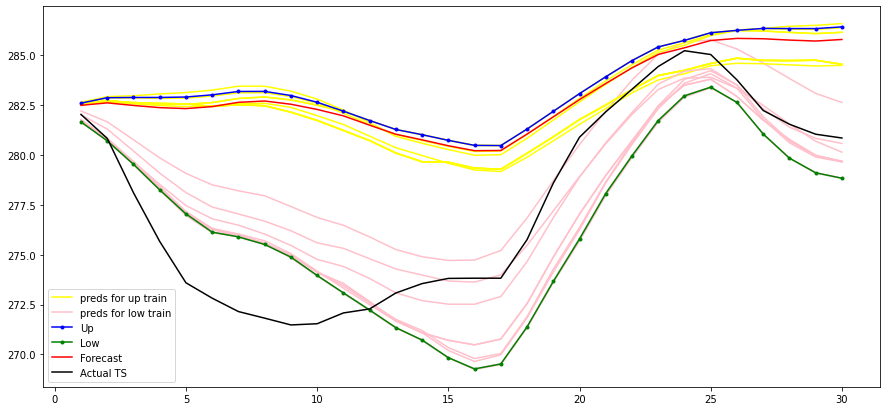

In [44]:
conf_int_plotting(up_predictions = x['up_predictions'],
                  low_predictions = x['low_predictions'],
                  regim='quantile',
                  plot_history = False,
                  plot_up_int = True,
                  plot_low_int = True,
                  plot_trend = False,
                  plot_forecast = True,
                  plot_upper_train = True,
                  plot_lower_train = True,
                  plot_ts_test = True)